# 1. Importing Libraries

In [36]:
import pandas as pd 
import numpy as np 
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split 
import seaborn as sns 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from BorutaShap import BorutaShap
from imblearn.combine import SMOTEENN


# 2. Reading Data

In [2]:
#this function is to read, transform and join 2 data frame

def read_features():
    path = 'secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature_'+str(x+1) for x in range(len(df.columns))]
    return df



def read_target():
    path = 'secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df

#for the testing purporse, trim to remain first 100 rows only
X = read_features()
y = read_target().iloc[:,0]

In [3]:
#Row & Columns of Features 
X.shape

(1567, 590)

# 3. Splitting Training & Testing Data

In [4]:
#Splitting the Data: 80% Training, 20% Testing Data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1,stratify=y)

In [5]:
#Rows and Columns of X_Train DF
x_train.shape

(1253, 590)

In [6]:
#Rows and Columns of X_Train DF
x_test.shape

(314, 590)

# 4. Reducing Dimensionality

## 4.1. Remove duplicated Columns

In [7]:
#Function for finding and removing duplicated columns (features)
def remove_duplicated_columns(df):
    dict_duplicate_pair = {}
    dict_duplicate_matches = {}
    list_duplicate = []
    to_remove = []
    for i in range(0, len(df.columns)):
        l = []
        for j in range(i+1,len(df.columns)):
            dict_duplicate_pair[str(i+1)+';'+str(j+1)] = df.iloc[:,i].equals(df.iloc[:,j])
            if df.iloc[:,i].equals(df.iloc[:,j]) == True:
                if j not in list_duplicate:
                    l.append(j)
                    to_remove.append('feature_'+str(j+1))
                list_duplicate.append(i)
                list_duplicate.append(j)
        if len(l)!=0:
            dict_duplicate_matches[i] = l


    df_duplicate_pair = pd.DataFrame.from_dict(dict_duplicate_pair, orient='index')
    df_duplicate_pair.columns=['duplicate']

    df_duplicate_matches = pd.DataFrame.from_dict(dict_duplicate_matches, orient='index')

    
    df = df.drop(columns=to_remove, axis = 1)

    return df

In [8]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_duplicated_columns(x_train)
x_train.shape

(1253, 486)

## 4.2. Removing Features with Constant Volatility

In [9]:
#Defining function to find and remove features with zero standard deviation 
def remove_constant_volatility(df):
    df_EDA= df.describe().T
    df_EDA= df_EDA[df_EDA["std"] == 0]
    df = df.drop(axis=1, columns=df_EDA.index)
    return df

In [10]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_constant_volatility(x_train)
x_train.shape

(1253, 474)

## 4.3. Remove Features with high % of Missing Values

In [11]:
#Defining function to remove features with a given % of missing values 
def remove_cols_with_high_pct_null(df, null_threshold):
    list_column_with_pct_null = pd.concat([df.isnull().sum(), df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    list_column_with_pct_null= list_column_with_pct_null[list_column_with_pct_null["Percentage (%)"] >= null_threshold]
    df = df.drop(axis=1, columns=list_column_with_pct_null.index)
    return df

In [12]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_cols_with_high_pct_null(x_train, 0.8)
x_train.shape

(1253, 466)

# 5. Outlier & Missing Value Treatment

In [21]:
#Function to drop Outliers and impute Missing Values with KNN 
def outlierknn(df):
    #Outlier treatment first:
    for col in df.columns:
        ll_col = df[col].mean() - 3 * df[col].std()
        ul_col = df[col].mean() + 3 * df[col].std()
        df[col] = np.where(df[col]>ul_col,np.NaN,np.where(df[col]<ll_col,np.NaN,df[col]))
    #Scaling data 
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)
    #KNN Imputation 
    knn = KNNImputer(n_neighbors=5, weights='distance')
    df = pd.DataFrame(knn.fit_transform(df), columns=df.columns)
    #Reverse Scaling
    df = pd.DataFrame(scaler.inverse_transform(df), columns= df.columns)
    return df  

In [15]:
#Using function above on x_train
x_train = outlierknn(x_train)

# 6. Feature Selection

In [22]:
#This is BorutaShap with TENTATIVE features

#list_method=['shap','gini']

def BorutaShap_FS (X, y,method_option) :
    #modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, class_weight='balanced_subsample', max_depth=5, random_state=100)
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)

    # define model for resp. classifier
    modelshap.fit(X,y)
    feature_names = np.array(X.columns)
    # define Boruta Sahp feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure=method_option,
                              classification=True)  # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = False,random_state=100)  
    #feature_selector.plot(which_features='accepted',figsize=(20,10))
    tentative=X.loc[:,feature_selector.tentative]
    selected=feature_selector.Subset()
    selten=pd.concat([selected,tentative],axis=1)
    # call transform() on X to filter it down to selected features
    return  selten

In [23]:
x_train = BorutaShap_FS(x_train,y_train,'shap')

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
#Shape of x_train after Feature Selection
x_train.shape

(1253, 14)

In [28]:
#Correlation Matrix of Remaining Features
x_train.corr()

,feature_124,feature_563,feature_133,feature_60,feature_66,feature_342,feature_332,feature_349,feature_148,feature_442,feature_206,feature_478,feature_476,feature_421
feature_124,1.000000,-0.058645,-0.198523,0.049122,-0.074414,-0.016216,0.111024,0.019627,-0.012134,0.020943,-0.004297,-0.000838,0.172050,-0.011260
feature_563,-0.058645,1.000000,-0.190573,-0.051219,0.037487,-0.018479,-0.047357,-0.015048,0.417714,-0.090442,-0.034604,-0.034569,-0.000112,0.413384
feature_133,-0.198523,-0.190573,1.000000,0.166136,0.016326,0.102905,0.016764,0.042093,0.005931,0.152847,0.095612,0.094184,-0.023777,0.008061
feature_60,0.049122,-0.051219,0.166136,1.000000,-0.381982,0.196641,-0.016146,0.267862,0.261183,0.115820,0.207963,0.212991,-0.088444,0.262258
feature_66,-0.074414,0.037487,0.016326,-0.381982,1.000000,0.024473,-0.135266,0.045110,0.033594,0.003193,0.015304,0.010843,-0.123287,0.032243
feature_342,-0.016216,-0.018479,0.102905,0.196641,0.024473,1.000000,-0.108577,0.071085,0.129037,0.093725,0.967640,0.965696,0.034713,0.129611
feature_332,0.111024,-0.047357,0.016764,-0.016146,-0.135266,-0.108577,1.000000,-0.056560,-0.023986,0.074418,-0.085761,-0.088714,0.598492,-0.022313
feature_349,0.019627,-0.015048,0.042093,0.267862,0.045110,0.071085,-0.056560,1.000000,0.155351,0.017429,0.075458,0.077981,-0.098460,0.155661
feature_148,-0.012134,0.417714,0.005931,0.261183,0.033594,0.129037,-0.023986,0.155351,1.000000,0.025682,0.125767,0.127811,-0.008694,0.999892
feature_442,0.020943,-0.090442,0.152847,0.115820,0.003193,0.093725,0.074418,0.017429,0.025682,1.000000,0.097813,0.097734,0.056700,0.027377


Text(0.5, 1.0, 'Correlation of remaining Features')

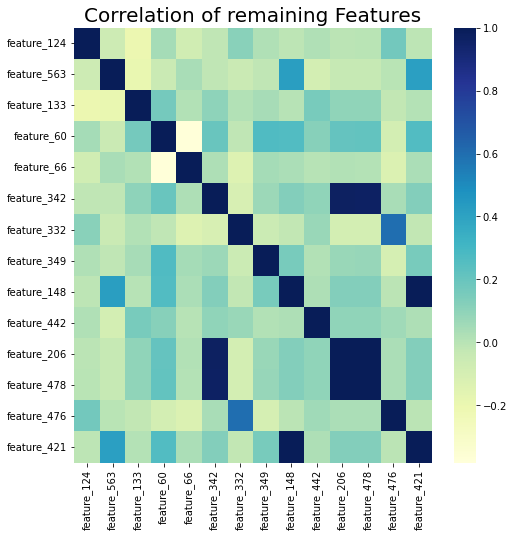

In [27]:
#Heatmap of Correlation of Remaining Feaures 
plt.rcParams['figure.figsize'] = (8, 8) #this is to set the size for the plot, making it bigger
sns.heatmap(x_train.corr(), cmap = "YlGnBu")
plt.title('Correlation of remaining Features', fontsize = 20)

# 7. Multicolinearity Treatment

In [29]:
#Remove the highly collinear features from data
def remove_collinear_features(x, threshold):


    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                #Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [32]:
x_train=remove_collinear_features(x_train, 0.7)
x_train.shape

(1253, 11)

Text(0.5, 1.0, 'Correlation of remaining Features')

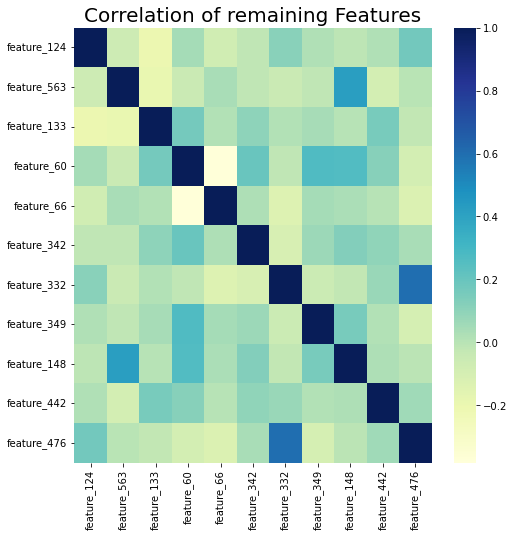

In [33]:
#Heatmap of Correlation of Remaining Feaures 
plt.rcParams['figure.figsize'] = (8, 8) #this is to set the size for the plot, making it bigger
sns.heatmap(x_train.corr(), cmap = "YlGnBu")
plt.title('Correlation of remaining Features', fontsize = 20)

# 8. Balancing

In [34]:
#Function SMOTEENN
def sampling(X_train, y_train):
    sampler = SMOTEENN(random_state=100)
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# X_train, y_train = sampling(X_train, y_train,'SMOTE')
# X_train.shape

In [38]:
x_train, y_train = sampling(x_train, y_train)

(2002,)

# 9. Modeling